## FEN Generator

The goal of the project is to build a model able to generate [Forsyth–Edwards Notation
](https://en.wikipedia.org/wiki/Forsyth%E2%80%93Edwards_Notation) (FEN) description based on a schematic image of a chess board.

In [5]:
from toai.imports import *
import tensorflow as tf
from tensorflow import keras
import os
import re

In [113]:
%matplotlib inline

Configuring GPU to allow memory growth to avoid OOM kernel crashes 

In [6]:
tf.debugging.set_log_device_placement(False)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            print(gpu)
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
1 Physical GPUs, 1 Logical GPUs


Define datasets for data location

In [7]:
DATA_DIR = Path('data/chess')
TEMP_DIR = Path('temp/chess')
TRAIN_DATA_DIR = DATA_DIR/"train"
TEST_DATA_DIR = DATA_DIR/"test"
DOWNLOAD_DATA = False
TEST_DATA_SIZE = 10000

In [8]:
DATA_DIR.mkdir(parents=True, exist_ok=True)
TEMP_DIR.mkdir(parents=True, exist_ok=True)

In [9]:
if DOWNLOAD_DATA:
    !kaggle datasets download -d koryakinp/chess-positions --unzip -p {DATA_DIR}

Define couple helper classes for easier data manipulation

In [39]:
def ceate_df(data_path, size=TEST_DATA_SIZE):
    file_paths = [data_path/fn for fn in os.listdir(data_path)]
    tuples = [(path.stem, str(path)) for path in file_paths[:size]]
    return pd.DataFrame(list(tuples), columns=["fen", "path"])

In [40]:
df = ceate_df(TRAIN_DATA_DIR)

In [41]:
df.head()

fen  \
0            8-3pPKp1-7p-8-1N4k1-7P-8-7R   
1    KR3k2-8-1P4Pp-3P4-7P-2Nb4-2b4n-4B2N   
2    7n-N5B1-2p5-2KN4-n3r3-N2BrkpB-4r3-8   
3               1r6-8-1R6-6k1-B7-8-2K5-8   
4  nN4B1-1b1B4-r7-8-5PN1-KPk5-3P4-B1B3R1   

                                                path  
0  data/chess/train/8-3pPKp1-7p-8-1N4k1-7P-8-7R.jpeg  
1  data/chess/train/KR3k2-8-1P4Pp-3P4-7P-2Nb4-2b4...  
2  data/chess/train/7n-N5B1-2p5-2KN4-n3r3-N2BrkpB...  
3     data/chess/train/1r6-8-1R6-6k1-B7-8-2K5-8.jpeg  
4  data/chess/train/nN4B1-1b1B4-r7-8-5PN1-KPk5-3P...

In [45]:
train_data, val_data = train_test_split(df, test_size=0.2, random_state=42)

In [43]:
chess_pieses = 'prbnkqPRBNKQ'
SQUARE_SIZE = 71
IMG_DIM = SQUARE_SIZE * 8
IMG_DIMS = (IMG_DIM, IMG_DIM)

In [11]:
def onehot_from_fen(fen):
    eye = np.eye(13)
    output = np.empty((0, 13))
    fen = re.sub('[-]', '', fen)
   
    for char in fen:
        if(char in '12345678'):
            output = np.append(output, np.tile(eye[12], (int(char), 1)), axis=0)
        else:
            idx = chess_pieses.index(char)
            output = np.append(output, eye[idx].reshape((1, 13)), axis=0)

    return output.astype(int)

In [12]:
def process_image(image):
    image = tf.image.resize(image, IMG_DIMS)
    
    image = tf.expand_dims(image, 0)
    patches = tf.image.extract_patches(
        images=image, 
        sizes=[1, SQUARE_SIZE, SQUARE_SIZE, 1], 
        strides=[1, SQUARE_SIZE, SQUARE_SIZE, 1], 
        rates=[1, 1, 1, 1],
        padding='VALID'
    )
        
    patches = tf.squeeze(patches, axis=0)
   
    return tf.reshape(patches, [64, SQUARE_SIZE, SQUARE_SIZE, 3])

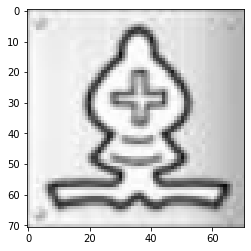

In [17]:
image_file = train_data['path'].values[0]
image_file = tf.io.read_file(image_file)

image = tf.image.decode_jpeg(image_file, channels=3)
image = tf.image.convert_image_dtype(image, dtype=tf.float32)

patches = process_image(image)
patch1 = patches[15]

plt.imshow(patch1)
plt.show()

In [46]:
def image_parse(filepath, preprocess_fn, img_dims):
    image_file = tf.io.read_file(filepath)
    image = tf.image.decode_jpeg(image_file, channels=3)
    image = preprocess_fn(image)
    return image

In [47]:
def prepare_ds(df, batch_size, parse_fn, shuffle=False, augment_fn=None, num_parallel_calls=-1):
    dataset_length = len(df)
    
    preprocess_fn = partial(tf.image.convert_image_dtype, dtype=tf.float32)
    parse_fn = partial(parse_fn, preprocess_fn=preprocess_fn, img_dims=IMG_DIMS)
    labels = [onehot_from_fen(fen) for fen in df.fen]
    
    label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(labels, tf.float32)).unbatch()
    
    dataset = (
        tf.data.Dataset.from_tensor_slices(df.path.values)
        .map(parse_fn, num_parallel_calls=num_parallel_calls)
        .map(augment_fn, num_parallel_calls=num_parallel_calls)
    ).unbatch()
    
    ds = tf.data.Dataset.zip((dataset, label_ds))
    
    if shuffle:
        ds = ds.shuffle(dataset_length)
    
    ds = ds.batch(batch_size)
    ds = ds.repeat()
    ds = ds.prefetch(1)
    return ds, dataset_length, batch_size

In [48]:
train_dataset, train_dataset_length, train_batch_size = prepare_ds(
    train_data,
    batch_size=16,
    shuffle=True,
    parse_fn=image_parse, 
    augment_fn=process_image
)

In [49]:
val_dataset, val_dataset_length, val_batch_size = prepare_ds(
    train_data,
    batch_size=16,
    shuffle=False,
    parse_fn=image_parse,
    augment_fn=process_image
)

In [11]:
def plot_dataset(dataset, rows, cols):
    _, ax = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows))
    for i, (x, y) in enumerate(dataset.take(rows * cols)):
        ax[i // cols, i % cols].axis('off')
        ax[i // cols, i % cols].imshow(x[0])

Executing op TakeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op IteratorGetNextSync in device /job:localhost/replica:0/task:0/device:CPU:0


TypeError: Invalid shape (64, 40, 40, 3) for image data

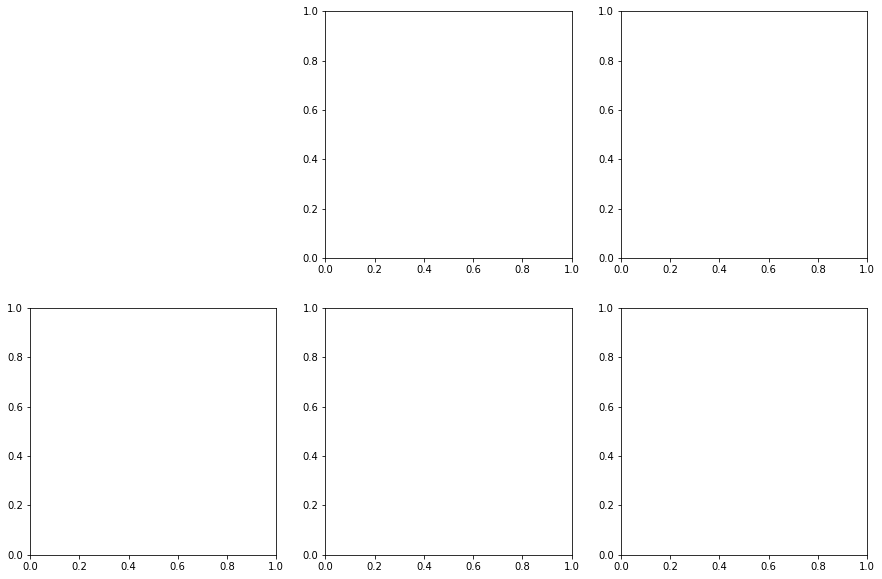

In [189]:
plot_dataset(train_dataset, 2, 3)

In [15]:
def make_model(
    n_classes,
    input_shape,
    dropout=0.0,
    l1=1e-8,
    l2=1e-8,
):
    base_model = keras.applications.Xception(include_top=False, input_shape=input_shape)
    x = keras.layers.concatenate([
        keras.layers.GlobalAvgPool2D()(base_model.output),
        keras.layers.GlobalMaxPool2D()(base_model.output),
    ])
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(dropout)(x)
    x = keras.layers.Dense(
        n_classes,
        kernel_regularizer=keras.regularizers.l1_l2(l1, l2),
        activation=keras.activations.softmax,
    )(x)
    
    return keras.Model(inputs=base_model.inputs, outputs=x)

Sanity check of datasets before starting the traingin

In [50]:
print(train_dataset)
print(val_dataset)

<PrefetchDataset shapes: ((None, 71, 71, 3), (None, 13)), types: (tf.float32, tf.float32)>
<PrefetchDataset shapes: ((None, 71, 71, 3), (None, 13)), types: (tf.float32, tf.float32)>


In [51]:
def train_model(model, optimizer, lr, epochs, easing_epochs):
    model.compile(
        optimizer=optimizer(lr),
        loss=keras.losses.categorical_crossentropy,
        metrics=[
            keras.metrics.categorical_accuracy,  
        ],
    )
    
    reduce_lr_patience = max(5, epochs//4)
    early_stopping_patience = reduce_lr_patience * 2
    
    history = model.fit(
        x=train_dataset,
        steps_per_epoch=math.ceil(train_dataset_length/train_batch_size),
        validation_data=val_dataset,
        validation_steps=math.ceil(val_dataset_length/val_batch_size),
        epochs=epochs,
        callbacks=[
            keras.callbacks.ReduceLROnPlateau(factor=0.3, patience=reduce_lr_patience),
            keras.callbacks.EarlyStopping(patience=early_stopping_patience, restore_best_weights=True),
        ],
        verbose=1,
    )
    
    return history

In [52]:
model = make_model(
    n_classes=13,
    input_shape=(71, 71, 3),
    dropout=0.2,
    l1=3e-6,
    l2=3e-5,
)

In [37]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 71, 71, 3)]  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 35, 35, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 35, 35, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 35, 35, 32)   0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

In [53]:
history = train_model(
    model=model,
    optimizer=keras.optimizers.Adam,
    lr=1e-4,
    epochs=6,
    easing_epochs=0,
)

Epoch 1/6


W0821 17:20:10.622569 139774420531008 deprecation.py:323] From /home/martynas/.local/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


500/500 [==============================] - 72s 143ms/step - loss: 0.5365 - categorical_accuracy: 0.9104 - val_loss: 0.1100 - val_categorical_accuracy: 0.9812
Epoch 2/6
500/500 [==============================] - 42s 84ms/step - loss: 0.2836 - categorical_accuracy: 0.9611 - val_loss: 0.0886 - val_categorical_accuracy: 0.9860
Epoch 3/6
500/500 [==============================] - 42s 85ms/step - loss: 0.2237 - categorical_accuracy: 0.9703 - val_loss: 0.0480 - val_categorical_accuracy: 0.9940
Epoch 4/6
500/500 [==============================] - 42s 85ms/step - loss: 0.1671 - categorical_accuracy: 0.9789 - val_loss: 0.5911 - val_categorical_accuracy: 0.9535
Epoch 5/6
500/500 [==============================] - 43s 86ms/step - loss: 0.1566 - categorical_accuracy: 0.9821 - val_loss: 0.3296 - val_categorical_accuracy: 0.9730
Epoch 6/6
500/500 [==============================] - 42s 84ms/step - loss: 0.1180 - categorical_accuracy: 0.9866 - val_loss: 0.0139 - val_categorical_accuracy: 0.9980


In [54]:
best_model_arch_path = str(TEMP_DIR/'best_model.json')
best_model_weights_path = str(TEMP_DIR/'best_model.h5')

In [55]:
model.save_weights(best_model_weights_path)
with open(best_model_arch_path, "w") as f:
    f.write(model.to_json())

In [56]:
def plot_history(history, contains: str, skip=0):
    df = pd.DataFrame(history.history)
    df[list(df.filter(regex=contains))].iloc[skip:].plot()

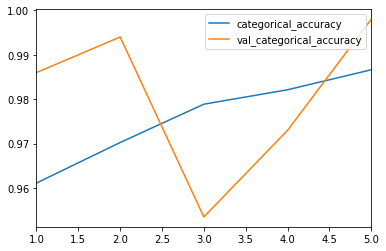

In [60]:
plot_history(history, "acc", 1)

In [20]:
test_data = ceate_df(TEST_DATA_DIR)

In [1]:
def prepare_test_ds(df, batch_size, parse_fn, augment_fn=None, num_parallel_calls=-1):
    dataset_length = len(df)
    
    preprocess_fn = partial(tf.image.convert_image_dtype, dtype=tf.float32)
    parse_fn = partial(parse_fn, preprocess_fn=preprocess_fn, img_dims=IMG_DIMS)
    
    ds = (
        tf.data.Dataset.from_tensor_slices(df.path.values)
        .map(parse_fn, num_parallel_calls=num_parallel_calls)
        .map(augment_fn, num_parallel_calls=num_parallel_calls)
    ).unbatch()
    
    ds = ds.batch(batch_size)
    ds = ds.repeat()
    ds = ds.prefetch(1)
    return ds, dataset_length, batch_size

In [32]:
test_dataset, test_dataset_length, test_batch_size = prepare_test_ds(
    test_data,
    batch_size=8,
    parse_fn=image_parse, 
    augment_fn=process_image
)

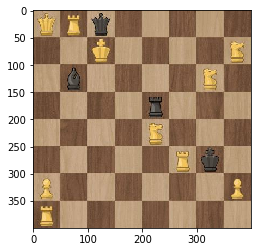

In [103]:
image_file = test_data['path'].values[15]
image_file = tf.io.read_file(image_file)
image = tf.image.decode_jpeg(image_file, channels=3)
image = tf.image.convert_image_dtype(image, dtype=tf.float32)
plt.imshow(image)
plt.show()

In [104]:
image_file = test_data['path'].values[15]
image_file = tf.io.read_file(image_file)

image = tf.image.decode_jpeg(image_file, channels=3)
image = tf.image.convert_image_dtype(image, dtype=tf.float32)
image = process_image(image)

In [33]:
prediction = model.predict_generator(test_dataset, steps=test_dataset_length/test_batch_size)

In [34]:
prediction.shape

(10000, 13)

In [49]:
test_data['fen'].values[0]

'8-2K1P3-8-6P1-1B1pP3-1N2kbr1-4R2n-5r2'

In [25]:
def fen_from_onehot(one_hot):
    output = ''
    for j in range(8):
        for i in range(8):
            if(one_hot[j][i] == 12):
                output += ' '
            else:
                output += chess_pieses[one_hot[j][i]]
        if(j != 7):
            output += '-'

    for i in range(8, 0, -1):
        output = output.replace(' ' * i, str(i))

    return output

In [26]:
fen_from_onehot(prediction.argmax(axis=1).reshape(8, 8)) == test_data['fen'].values[0]

True

In [106]:
# Extracts the outputs of the top 12 layers
layer_outputs = [layer.output for layer in model.layers[:20]]
# Creates a model that will return these outputs, given the model input
activation_model = keras.models.Model(inputs=model.input, outputs=layer_outputs) 

In [107]:
activations = activation_model.predict(image) # Returns a list of five Numpy arrays: one array per layer activation

/home/martynas/.local/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.


RuntimeError: libpng signaled error

<Figure size 1152x0 with 1 Axes>

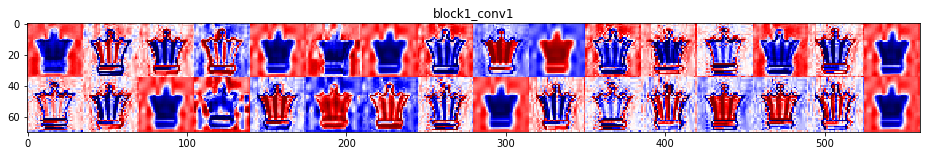

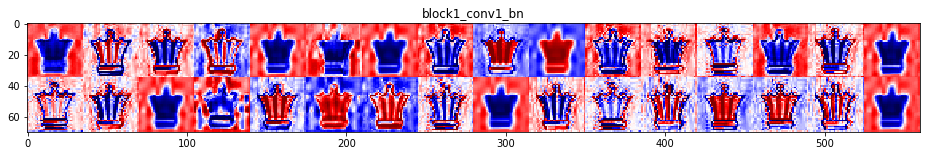

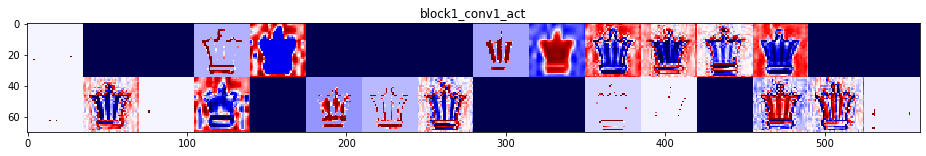

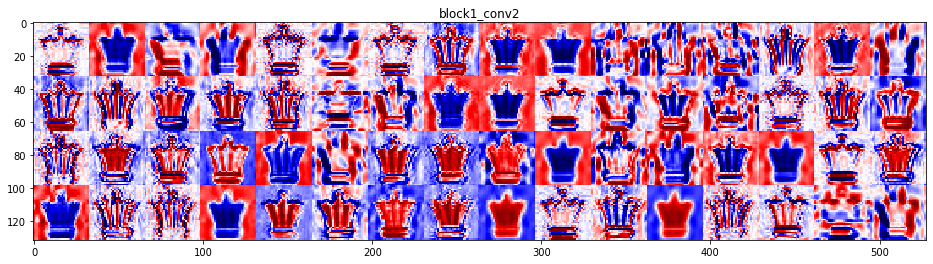

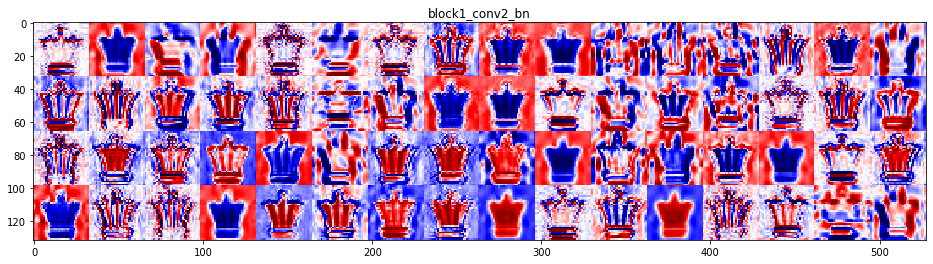

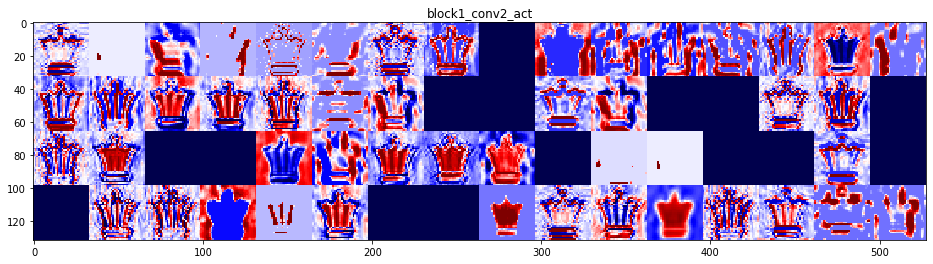

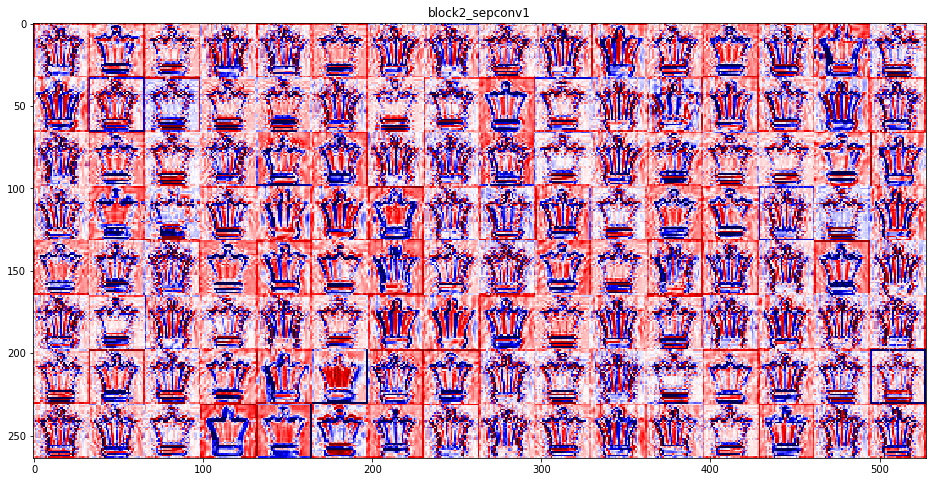

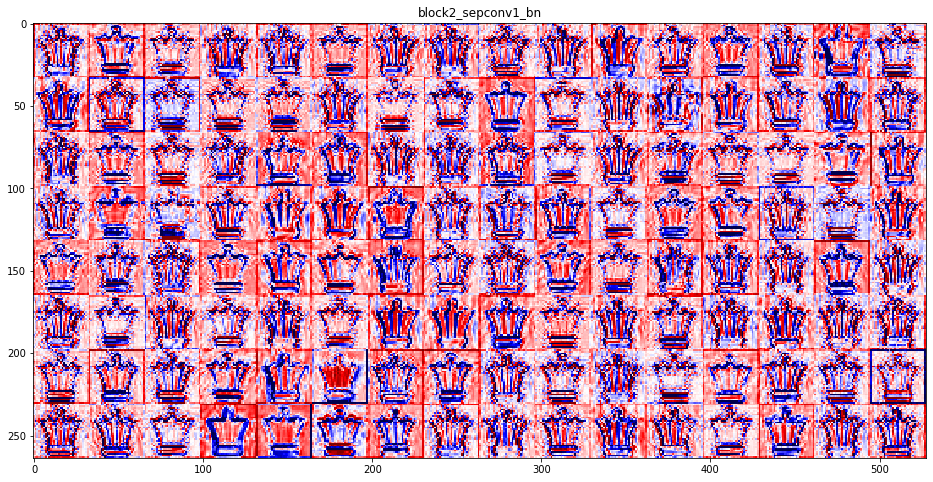

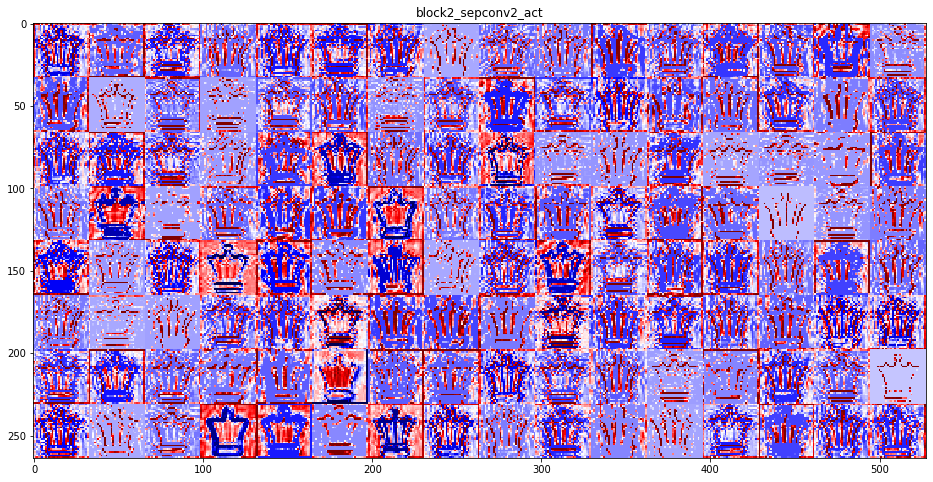

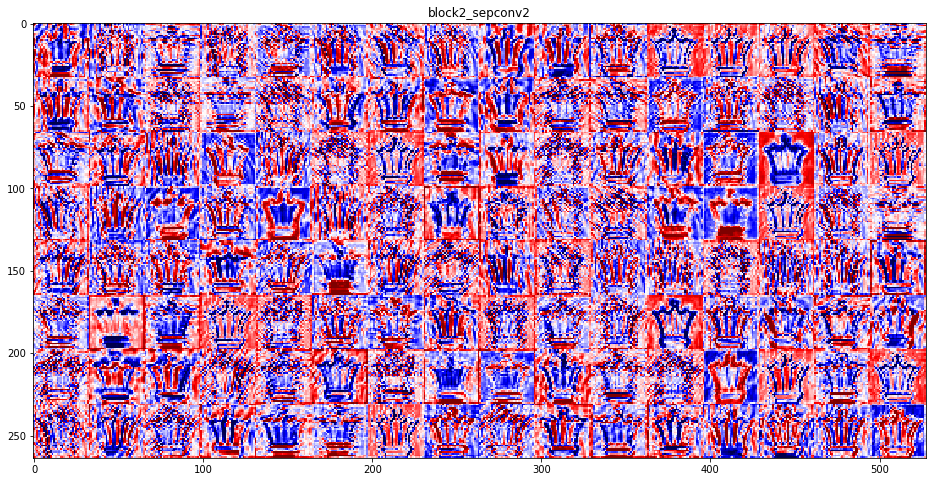

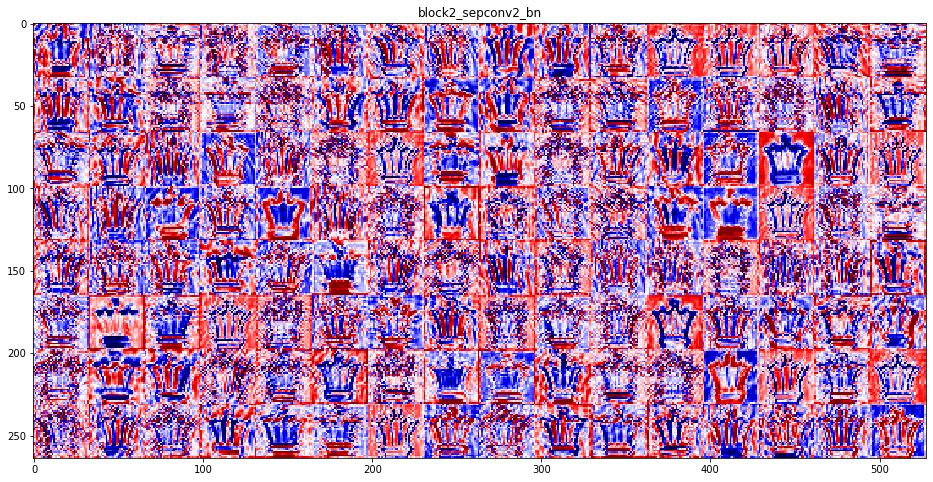

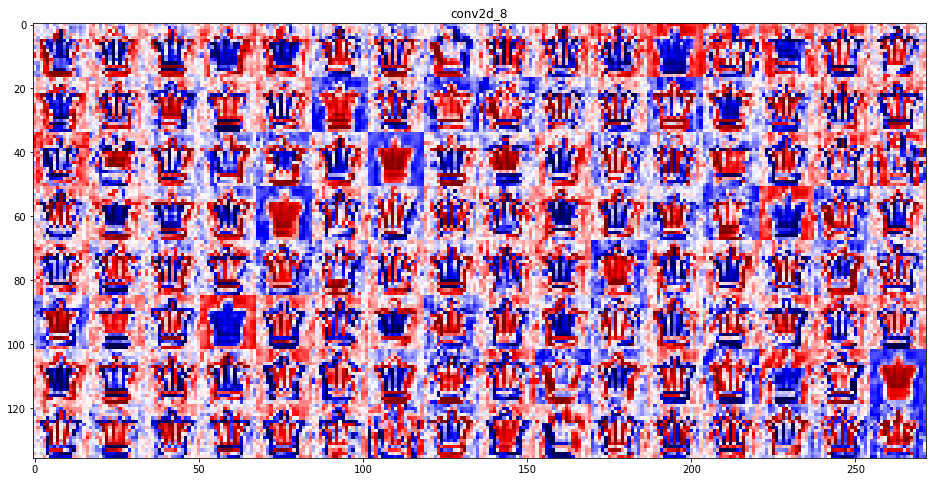

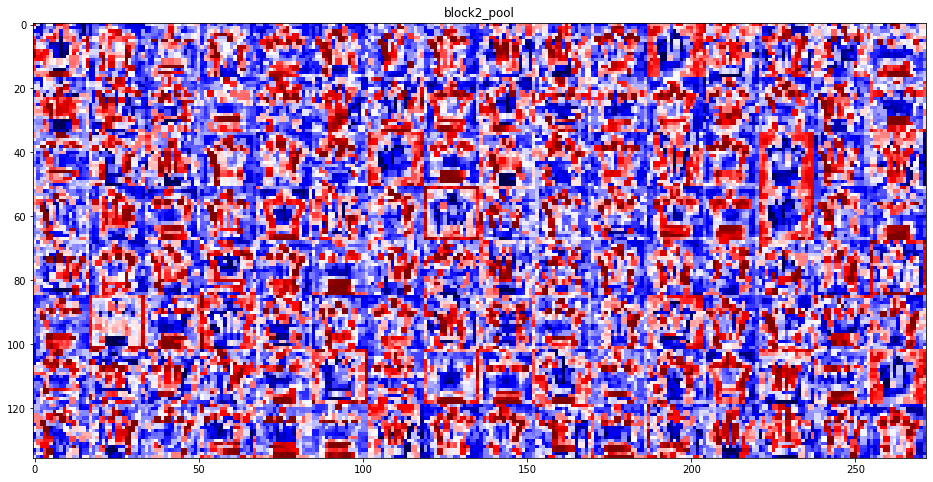

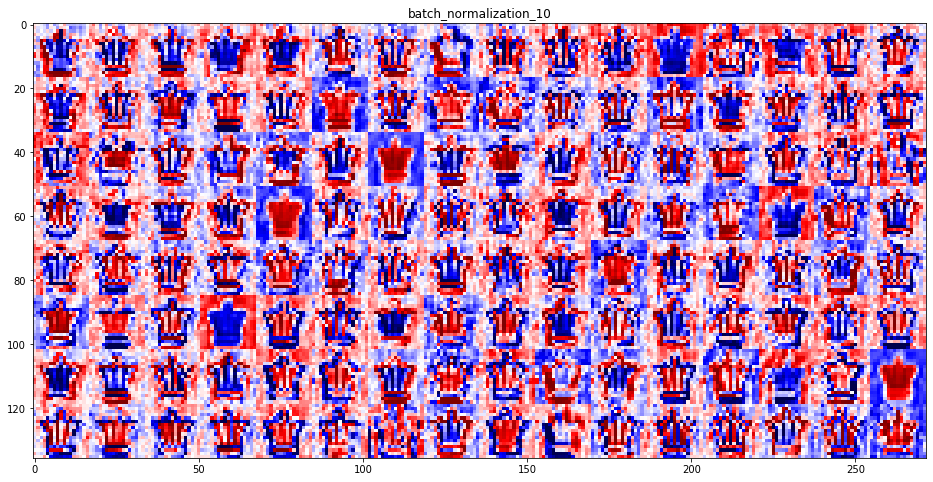

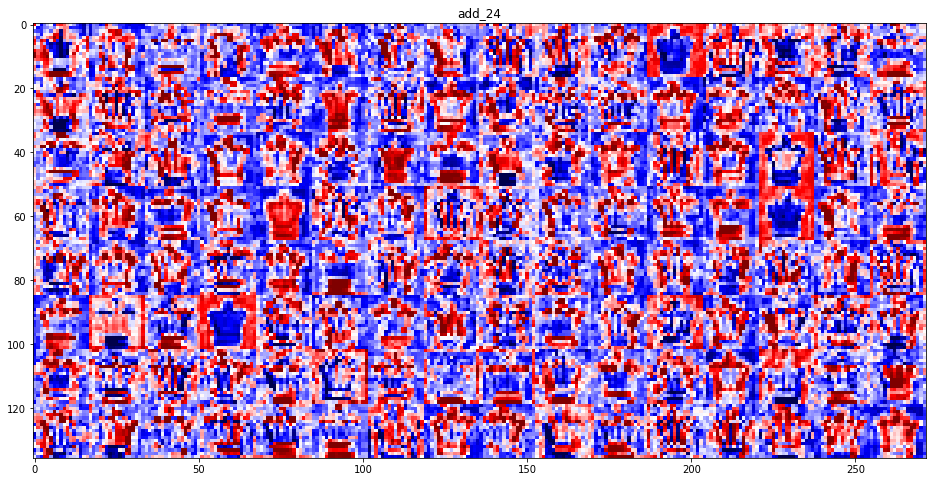

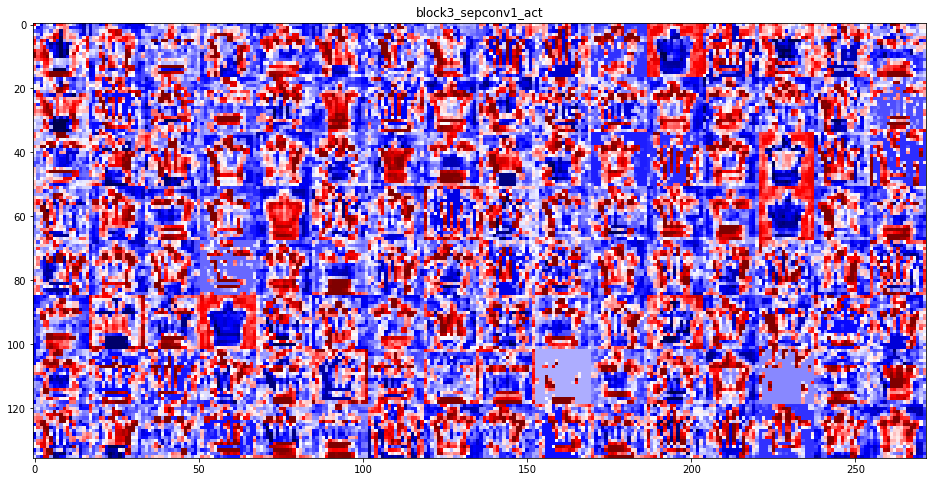

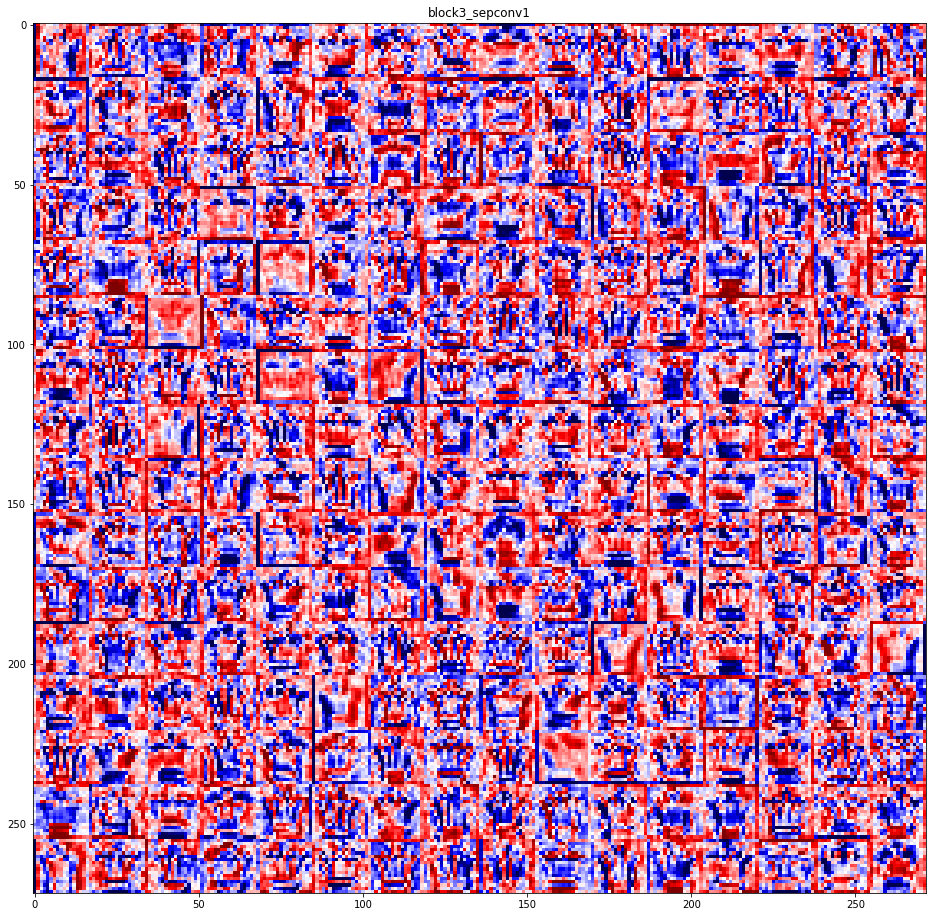

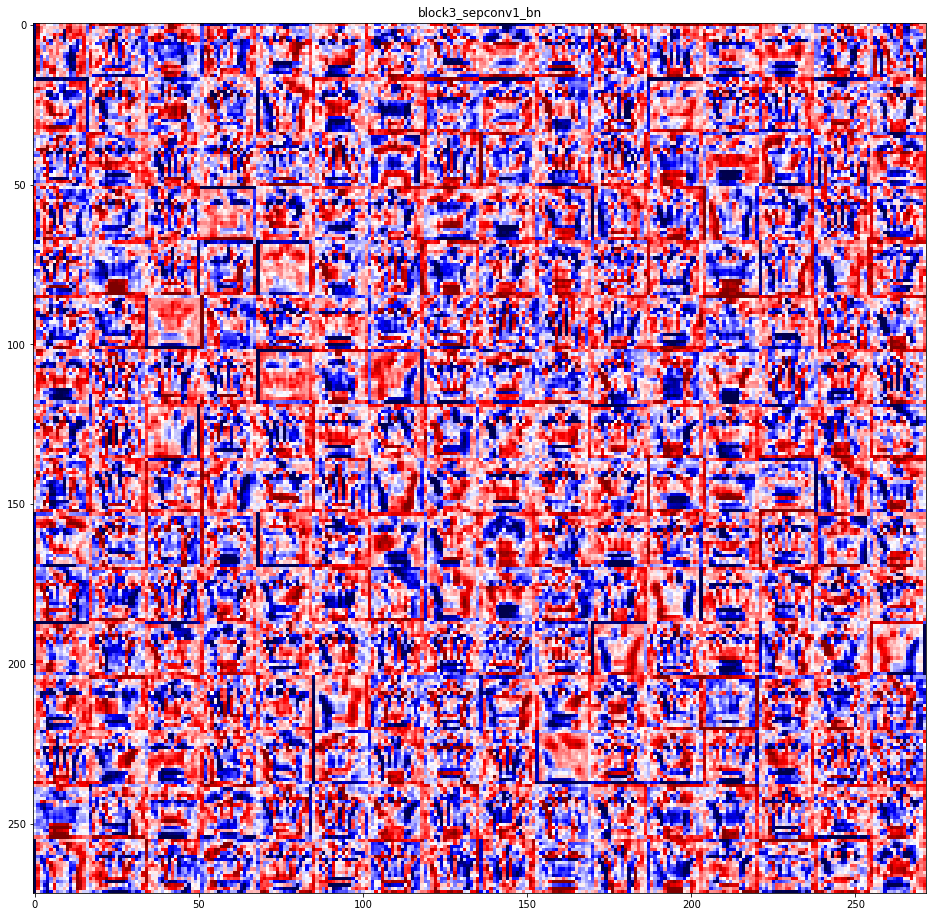

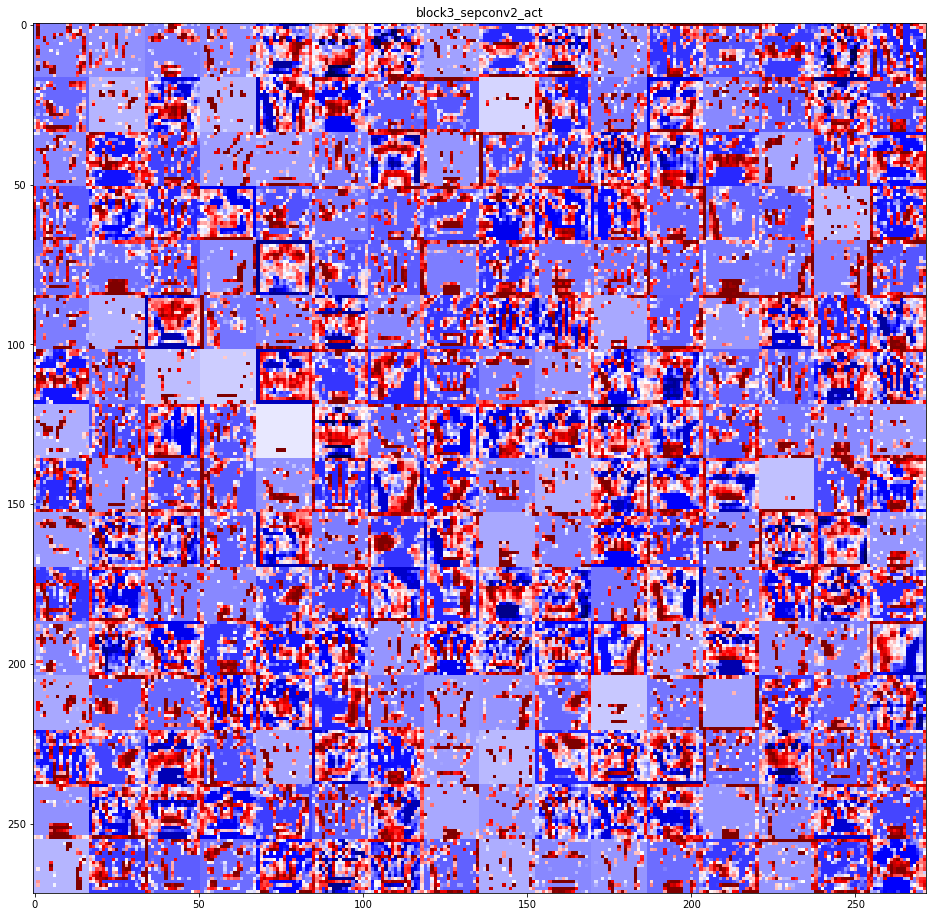

In [114]:
layer_names = []
for layer in model.layers[:20]:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
    
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='seismic')